# Time Stepping Schemes for ODEs

To simulate ocean circulation through time, we use time stepping schemes to determine the next model state given the current state. In this notebook, we'll look at a few approaches to implementing time stepping on a simple differential equation. Here, the goal will be to introduce several common schemes and take a look at their investigation rather than deriving the scheme from scratch along with the associated errors and stability.

## Overview
Time stepping refers to the process of predicting the state of a model at a time in the future given a function of the state at another time (which could be in  the past, present, future, or some combination of these states).   

**Import the modules for this notebook**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Model Example

**Differential Equation**

In this example, we'll be investigating the Logistic Differential Equation:

$$
\frac{dP}{dt} = rP\left(1-\frac{P}{K}\right)
$$

This equation is used to model population growth in a setting where the total population $P$ is limited by a carrying capacity $K$. In this equation $r$ is a growth rate that would hold if there were no constraints on growth. Here, we might consider $P$ the number of cells in a culture and $K$ the total number of cells that permissible in a given culture given nutrient availability, physical space, or some other constraint.

**Initial Conditions**

When modeling populations, we always start with an initial number of individuals $P_0$ i.e.

$$
P(0) = P_0
$$

**Intuitive Explanation**

In the absence of any constraints on growth, the growth rate of the population $dP/dt$ will grow exponentially with a growth rate $r$. We can see this in the equation by considering a small population $P$ relative to the carrying capacity. In this case, the term $\left(1-\frac{P}{K}\right)$ is close to 1 and we have a simple exponential growth equation $P'(t) = rP(t)$.

However, as $P$ start to approach the carrying capacity the $\left(1-\frac{P}{K}\right)$ approaches 0, and there is no further growth i.e. $P'(t) = 0$.

This type of equation is known as an **ordinary differential equation**. The *differential equation* part indicates that it is an equation that relates a function to one or more of its own derivatives. The *ordinary* part indicates that the derivatives are all with respect to the same variable. The previous example with the ball toss can also be thought of as a differential equation.

### Analytical Solution

It can be shown that analytical solution to this equation is 

$$
P(t) = \dfrac{P_0 K e^{rt}}{(K-P_0) + P_0 e^{rt}}
$$

Try differentiating this function and plugging it into differential equation to ensure that this function is indeed a solution.

Let's put some numbers on our equation and have a look at the solution.

In [2]:
# estimate initial conditions
P_0 = 10000

# starting and ending times (seconds)
t_min = 0.0 
t_max = 100.0

# define the carrying capacity
K = 100000

# define the growth rate
r = 0.1 

In [3]:
# make a time array for the analytical solution
t_analytical = np.arange(t_min, t_max, 0.01)

# make a function to compute the analytical solution
def P_analytical(t_analytical):
    return (P_0*K*np.exp(r*t_analytical))/((K-P_0) + P_0*np.exp(r*t_analytical))

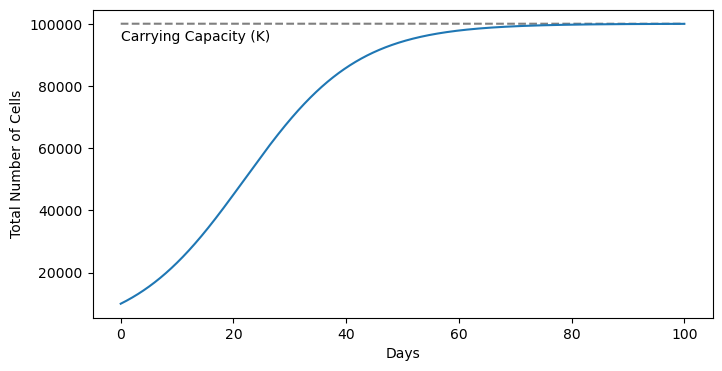

In [4]:
plt.figure(figsize=(8,4))
plt.plot(t_analytical, K*np.ones_like(t_analytical), 'k--', alpha=0.5)
plt.text(t_analytical[0],K*0.98,'Carrying Capacity (K)', ha='left',va='top')
plt.plot(t_analytical, P_analytical(t_analytical))
plt.ylabel('Total Number of Cells')
plt.xlabel('Days')
plt.show()

As we can see, the population grows quickly from its initial value and then starts to taper-off as it approaches the carrying capacity.

In the subsequent sections, we'll see how we can approximate this solution numerically.

## Numerical Solutions

All solutions to the differential equation derived numerically will follow series of discrete steps. Since we often think about these discrete steps in time, we can refer to these as *time stepping* schemes. Below, we will see 5 different implementations of time stepping schemes. They will all follow the same general formula as follows:

$$
P(t+\Delta t) \approx P(t) + \Delta t f(\cdots)
$$

Here, we estimate a future population value $P(t+\Delta t)$ as a function of the current population values $P(t)$ and a small difference estimated by the time step $\Delta t$ and $f$,  a function that will depend on values of $P$ at various time steps. In each of the cases below, the function $f$ is formulated a little different. Let's take a look.

## Euler's Methods

Euler's method is one of the simplest implementations of a numerical method for solving 

### Forward Euler

In the *Forward Euler* method, we express the population time $\Delta t$ in the future as a function of the temperature at the time $t$ and the rate of change at the time $t$:

$$
P(t+\Delta t) \approx P(t) +\Delta t \frac{dP(t)}{dt}
$$

In other words, 

$$
f(P(t)) = \frac{dP(t)}{dt}
$$

Using our differential equation, we can fill in this derivative as follows:

$$
P(t+\Delta t) \approx P(t) +\Delta t \frac{dP(t)}{dt} = P(t) +\Delta t \left[rP(t)\left(1-\frac{P(t)}{K}\right)\right]
$$

Not too bad! Let's code it up:

In [5]:
def forward_euler(dt, t_min, t_max, P_0, r, K):
    
    # compute number of timesteps
    nt = int((t_max-t_min)/dt) + 1 #number of points on t grid

    # make a time array
    t = np.linspace(t_min,t_max,nt)

    # establish the P grid
    P = np.zeros((nt,))
    
    # establish initial conditions
    P[0] = P_0
    
    # loop through each time step up until the last one
    for j in range(nt-1):
        P[j+1] = P[j] + dt * (r * P[j] * (1 - (P[j] / K)))
    
    return(t, P)

Next, we can apply our function with a given timestep:

In [6]:
dt = 10
t_forward_euler, P_forward_euler = forward_euler(dt, t_min, t_max, P_0, r, K)

We can also generate a function to see how our scheme worked out:

In [7]:
def plot_model_solution_vs_analytical(t, P, P_analytical, model_name):
    plt.figure(figsize=(8,4))
    plt.plot(t, K*np.ones_like(t), 'k--', alpha=0.5)
    plt.text(t[0],K*0.98,'Carrying Capacity (K)', ha='left',va='top')
    plt.plot(t, P, 'k.', label='Model Solution', markersize=10)
    plt.plot(t, P_analytical(t), label='Analytical Solution')
    plt.legend()
    plt.ylabel('Total Number of Cells')
    plt.xlabel('Days')
    plt.title('Analytical Solution vs Solution with '+model_name)
    plt.show()

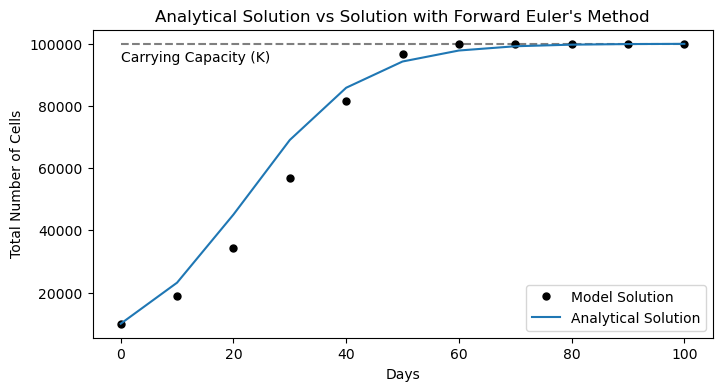

In [8]:
plot_model_solution_vs_analytical(t_forward_euler, P_forward_euler,
                                  P_analytical, "Forward Euler's Method")

Ok, it's not terrible, but the modeled curve seems to be lagging behind the true solution. If only we could strategically guess what way the curve was going to go - we'll see this in the next approach.

### Backward Euler

In the *Backward Euler* method, we express the population at a time $\Delta t$ in the future as a function of the temperature at the time $t$ and the rate of change at the time $t+\Delta t$ i.e. *in the future*. 

$$
P(t+\Delta t) \approx P(t) +\Delta t \frac{dP(t+\Delta t)}{dt}
$$

In other words, 

$$
f(P(t)) = \frac{dP(t+\Delta t)}{dt}
$$

Using our differential equation, we can fill in this derivative as follows:

$$
P(t+\Delta t) \approx P(t) +\Delta t \frac{dP(t+\Delta t)}{dt} = P(t) +\Delta t \left[rP(t+\Delta t)\left(1-\frac{P(t+\Delta t)}{K}\right)\right]
$$


Ok, this is a little trickier than the last approach. In the forward method, we have all of the information we need at a given time step to predict the next one. However, this model uses information from the future to predict the future - this type of scheme is known as an **implicit** scheme.

Not to worry, we can generate a scheme - we just need to ensure that there is a $P(t+\Delta t)$ term on the left hand side of the equation. With a little rearranging, we can write the problem like so:

$$
0 \approx P(t) + (\Delta t r - 1)P(t+\Delta t) - \left(\frac{\Delta t r}{K}\right)(P(t+\Delta t))^2
$$

Turns out, this is just a quadratic equation, which we solve with the quadratic formula:

$$
P(t+\Delta t) \approx \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

where

$$
\begin{align*}
a &= -\frac{\Delta t r}{K}\\
b &= \Delta t r - 1 \\
c &= P(t)
\end{align*}
$$

Thats a few more lines than the last scheme, but fundamentally, it's a very similar approrach. Let's code it up:

In [9]:
def backward_euler(dt, t_min, t_max, P_0, r, K):
    
    # compute number of timesteps
    nt = int((t_max-t_min)/dt) + 1 #number of points on t grid

    # make a time array
    t = np.linspace(t_min,t_max,nt)

    # establish the P grid
    P = np.zeros((nt,))
    
    # establish initial conditions
    P[0] = P_0
    
    # loop through each time step up until the last one
    for j in range(nt-1):
        a = -dt*r/K
        b = dt*r - 1
        c = P[j]
        P[j+1] = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    return(t, P)

We can test out scheme like before with the same time step and plotting function:

In [10]:
dt = 10
t_backward_euler, P_backward_euler = backward_euler(dt, t_min, t_max, P_0, r, K)

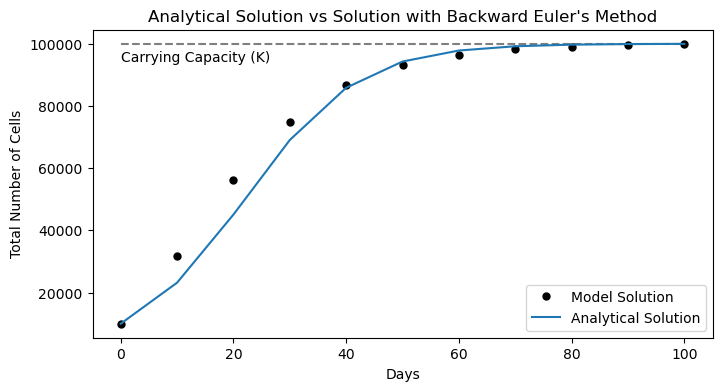

In [11]:
plot_model_solution_vs_analytical(t_backward_euler, P_backward_euler,
                                  P_analytical, "Backward Euler's Method")

Here, we see similar results as before, but now we have the opposite problem. Our numerical solution seems to be outpacing the analytical solution. If only we could split the difference...

### Crank-Nicolson Scheme

In the Crank-Nicolson scheme, we express the population at a time $\Delta t$ in the future as a function of the temperature at the time $t$ and a combination of the rates of change at the time $t$ *and* the time time $t+\Delta t$. Specifically, the combination is done as an average of the two. Borrowing the notation from above, we can express the scheme with

$$
f(P(t), P(t+\Delta t)) = \frac{1}{2}\left[\frac{dP(t)}{dt} + \frac{dP(t+\Delta t)}{dt}\right]
$$

This method can be thought of as a combination of the forward and backward Euler methods.

Using our differential equation, we again find that we need to do a little rearranging of our equation:

$$
P(t+\Delta t) \approx  P(t) +\frac{\Delta t}{2} \left[rP(t)\left(1-\frac{P(t)}{K}\right) + rP(t+\Delta t)\left(1-\frac{P(t+\Delta t)}{K}\right)\right]
$$

And we find that this is another quadratic equation situation with:

$$
0 \approx  \left[P(t) +\frac{\Delta t}{2} rP(t)\left(1-\frac{P(t)}{K}\right)\right] + \left[\frac{\Delta t}{2} r - 1\right]P(t+\Delta t) - \left(\frac{\Delta t r}{2 K}\right)(P(t+\Delta t))^2
$$

This is a very similar situation as the last method and we can again solve with the quadratic formula:

$$
P(t+\Delta t) \approx \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

where

$$
\begin{align*}
a &= -\frac{\Delta t r}{2 K}\\
b &= \frac{\Delta t}{2} r - 1\\
c &= P(t) +\frac{\Delta t}{2} rP(t)\left(1-\frac{P(t)}{K}\right)
\end{align*}
$$

In [20]:
def crank_nicolson(dt, t_min, t_max, P_0, r, K):
    
    # compute number of timesteps
    nt = int((t_max-t_min)/dt) + 1 #number of points on t grid

    # make a time array
    t = np.linspace(t_min,t_max,nt)

    # establish the P grid
    P = np.zeros((nt,))
    
    # establish initial conditions
    P[0] = P_0
    
    # loop through each time step up until the last one
    for j in range(nt-1):
        a = -dt * r/(2*K)
        b = (dt/2)*r - 1
        c = P[j] + ((dt/2)*r*P[j]*(1 - P[j]/K))
        P[j+1] = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    return(t, P)

Let's see how this looks:

In [21]:
dt = 10
t_crank_nicolson, P_crank_nicolson = crank_nicolson(dt, t_min, t_max, P_0, r, K)

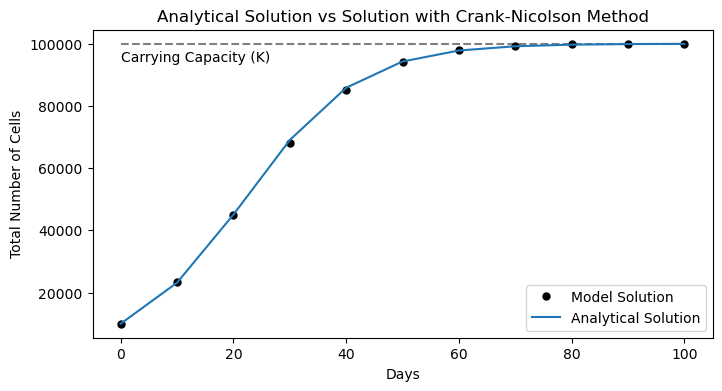

In [22]:
plot_model_solution_vs_analytical(t_crank_nicolson, P_crank_nicolson,
                                  P_analytical, "Crank-Nicolson Method")

Whoa! Much better! Turns out the Crank-Nicolson method is quite an improvement over the Forward and Backward Euler's method. We'll quantify just how much better below. But before we do, we need to address one of the drawbacks of this method - the implicit component. Here, we needed to know how to solve for the next time step and we used our differential equation to do so. Even in this simple scenario, we had to use the quadratic formula to solve for our scheme. But that approach is certainly not going to work for any old differential equation. Thus, we'd like to develop a scheme that only depends on the information we already have. We'll explore some options in the following two examples.

## Adams-Bashforth Schemes

The Adams-Bashforth method is similar to the schemes above but instead uses multiple past time steps to infer the predictive function. Here, we'll examine the Adams-Bashforth 2-step method which uses two past time steps as follows:

$$
f(P(t), P(t-\Delta t)) = \frac{1}{2} \left[ 3P(t) - P(t-\Delta t)\right]
$$

This method is faily easy to code up, as we'll see. The only catch is what happens at the first time step - since we need *two* time steps for the scheme to work, we don't have enought information at the beginning. To circumvent this issue, we'll use the basic Forward Euler's method for the first step, and then the Adams-Bashforth after that:

In [45]:
def adams_bashforth_2(dt, t_min, t_max, P_0, r, K):
    
    # compute number of timesteps
    nt = int((t_max-t_min)/dt) + 1 #number of points on t grid

    # make a time array
    t = np.linspace(t_min,t_max,nt)

    # establish the P grid
    P = np.zeros((nt,))
    
    # establish initial conditions
    P[0] = P_0
    
    # loop through each time step up until the last one
    for j in range(nt-1):
        if j==0:
            P[j+1] = P[j] + dt*( r*P[j]*(1-P[j]/K))
        else:    
            P[j+1] = P[j] + 0.5*dt*( 3*r*P[j]*(1-P[j]/K) - r*P[j-1]*(1-P[j-1]/K) )
    
    return(t, P)

Let's see how it performs:

In [46]:
dt = 10
t_AB2, P_AB2 = adams_bashforth_2(dt, t_min, t_max, P_0, r, K)

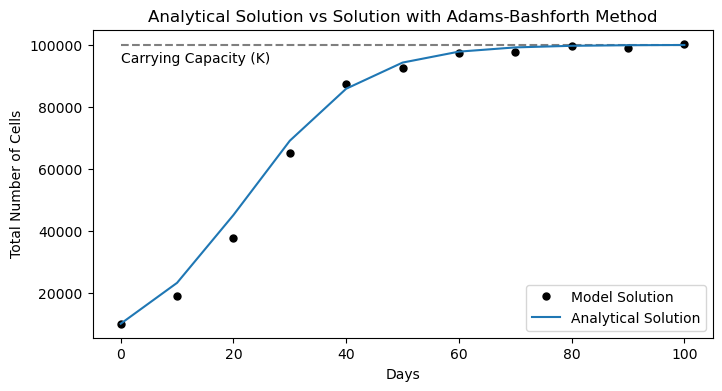

In [47]:
plot_model_solution_vs_analytical(t_AB2, P_AB2,
                                  P_analytical, "Adams-Bashforth Method")

Looking at the solution, it doesn't seem as accurate as the Crank-Nicolson method. But the real upshot here is that we never needed any implicit information. In this case, it's much easier to implement. The method can easily be extended to include additional steps from the past for enhanced numerical accuracy, but at higher numerical costs.

Let's take a look at one final approach.

## Runge-Kutta Schemes

The final example we'll examine is one used commonly for solving ODEs - the Runge-Kutta method. The Runge-Kutta method is a "family" of schemes with different orders pertaining to the number of terms in the scheme. A very common scheme is the 4th-order scheme, which we'll show here. 

To keep the notation clean(ish), let's express the right-hand side of our differential equation as a function $\mathcal{F}(P)$ i.e.

$$
\mathcal{F}(P) = rP\left(1-\frac{P}{K}\right)
$$

Then, the 4th-order Runge-Kutta scheme is given by

$$
f = \frac{1}{6} (k_1 + 2k_2 + 2k_3 + k_4) 
$$

where

$$
\begin{align*}
k_1 &= \mathcal{F}(P(t))\\
k_2 &= \mathcal{F}\left(P(t)+\frac{\Delta t}{2}k_1\right)\\
k_3 &= \mathcal{F}\left(P(t)+\frac{\Delta t}{2}k_2\right)\\
k_4 &= \mathcal{F}\left(P(t)+\Delta t k_3\right)\\
\end{align*}
$$

It is important to note that the $P$'s are always evaluated at the current time step and do not depend on properties in the future.

Now that we've gotten the scheme out of the way, we can write the 4 $k$ terms with our specific differential equation:

$$
\begin{align*}
k_1 &= rP(t)\left(1-\frac{P(t)}{K}\right)\\
k_2 &= r\left(P(t)+\frac{\Delta t}{2}k_1\right)\left(1-\frac{P(t)+\frac{\Delta t}{2}k_1}{K}\right)\\
k_3 &= r\left(P(t)+\frac{\Delta t}{2}k_2\right)\left(1-\frac{P(t)+\frac{\Delta t}{2}k_2}{K}\right)\\
k_4 &= r\left(P(t)+\Delta tk_3\right)\left(1-\frac{P(t)+\Delta tk_3}{K}\right)\\
\end{align*}
$$

Not so bad - let's code it up:

In [54]:
def runge_kutta_4(dt, t_min, t_max, P_0, r, K):
    
    # compute number of timesteps
    nt = int((t_max-t_min)/dt) + 1 #number of points on t grid

    # make a time array
    t = np.linspace(t_min,t_max,nt)

    # establish the P grid
    P = np.zeros((nt,))
    
    # establish initial conditions
    P[0] = P_0
    
    # loop through each time step up until the last one
    for j in range(nt-1):
        k1 = r * P[j] * (1- P[j]/K)
        k2 = r * (P[j] + (dt/2)*k1) * (1- (P[j] + (dt/2)*k1)/K)
        k3 = r * (P[j] + (dt/2)*k2) * (1- (P[j] + (dt/2)*k2)/K)
        k4 = r * (P[j] + (dt)*k3) * (1- (P[j] + (dt)*k3)/K)
        f = (1/6)*(k1+2*k2+2*k3+k4)
        P[j+1] = P[j] + dt*f
    return(t, P)

Let's see how it peforms:

In [55]:
dt = 10
t_RK4, P_RK4 = runge_kutta_4(dt, t_min, t_max, P_0, r, K)

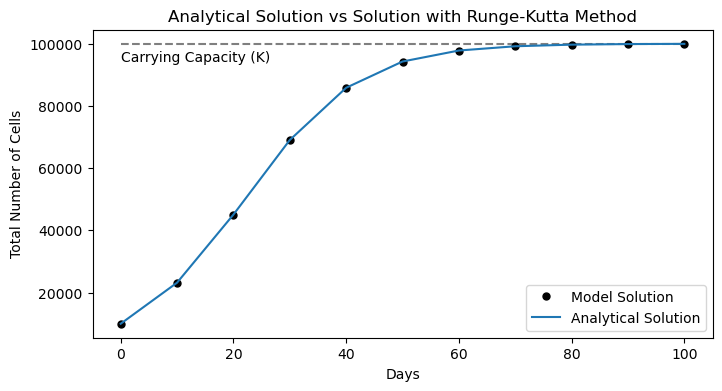

In [56]:
plot_model_solution_vs_analytical(t_RK4, P_RK4,
                                  P_analytical, "Runge-Kutta Method")

As we can see, the numerical solution matches quite well with the analytical solution! No wonder this scheme is so popular! It does come with some downsides though - notice that we needed to run 4 calculations to predict our next step which is much more than the other schemes. Here, we're encountering a trade-off between computations and accuracy. But just how accurate are all these methods? Let's test this numerically.

## Assessing Errors

A good textbook on numerical methods will give a derivation on the expected errors induced when using each of the schemes above. Here, we'll use the functions we've already define above to compute the errors for our example. Let's see how the errors compare across different timesteps:

In [57]:
# define a set of different time steps across orders of magnitude
timesteps = np.array([0.01,0.05, 0.1, 0.5, 1, 5, 10])

# make empy arrays to store errors in the model as a function of time step
forward_euler_errors = np.zeros_like(timesteps)
backward_euler_errors = np.zeros_like(timesteps)
crank_nicolson_errors = np.zeros_like(timesteps)
adams_bashforth_errors = np.zeros_like(timesteps)
runge_kutta_errors = np.zeros_like(timesteps)

# loop through and compute the errors for each scheme
for i, dt in enumerate(timesteps):

    # compute errors in forward Euler routine
    t_forward_euler, P_forward_euler = forward_euler(dt, t_min, t_max, P_0, r, K)
    forward_euler_errors[i] = np.sqrt(np.mean((P_forward_euler - P_analytical(t_forward_euler))**2))

    # compute errors in backward Euler routine
    t_backward_euler, P_backward_euler = backward_euler(dt, t_min, t_max, P_0, r, K)
    backward_euler_errors[i] = np.sqrt(np.mean((P_backward_euler - P_analytical(t_backward_euler))**2))

    # compute errors in Crank-Nicolson routine
    t_crank_nicolson, P_crank_nicolson = crank_nicolson(dt, t_min, t_max, P_0, r, K)
    crank_nicolson_errors[i] = np.sqrt(np.mean((P_crank_nicolson - P_analytical(t_crank_nicolson))**2))

    # compute errors in Adams Bashforth routine
    t_adams_bashforth, P_adams_bashforth = adams_bashforth_2(dt, t_min, t_max, P_0, r, K)
    adams_bashforth_errors[i] = np.sqrt(np.mean((P_adams_bashforth - P_analytical(t_adams_bashforth))**2))

    # compute errors in Runge Kutta routine
    t_runge_kutta, P_runge_kutta = runge_kutta_4(dt, t_min, t_max, P_0, r, K)
    runge_kutta_errors[i] = np.sqrt(np.mean((P_runge_kutta - P_analytical(t_runge_kutta))**2))

Let's see how they compare:

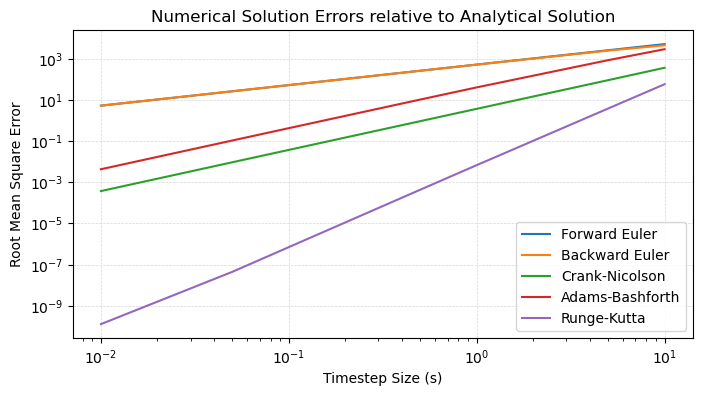

In [58]:
fig = plt.figure(figsize=(8,4))
plt.loglog(timesteps, forward_euler_errors, label='Forward Euler')
plt.loglog(timesteps, backward_euler_errors, label='Backward Euler')
plt.loglog(timesteps, crank_nicolson_errors, label='Crank-Nicolson')
plt.loglog(timesteps, adams_bashforth_errors, label='Adams-Bashforth')
plt.loglog(timesteps, runge_kutta_errors, label='Runge-Kutta')
plt.ylabel('Root Mean Square Error')
plt.xlabel('Timestep Size (s)')
plt.legend()
plt.title('Numerical Solution Errors relative to Analytical Solution')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

Ok, there's a lot to unpack here. First things first, it's important to note that the scales on both axes are logarithmic. This is important when comparing the errors - clearly we see that the Runge-Kutta-4 method has the smallest errors, followed by Crank-Nicolson and then Adams-Bashforth-. However, the differences in errors span *orders of magnitude*. Furthermore, as the time step decreases, the Runge-Kutta method gets *exponentially* bette compared to the other methods, as a result of it being a 4th-order scheme. The Crank-Nicolson and Adams-Bashforth-2 schemes are both 2nd-order schemes, and their performance increases at similar rates with declining timesteps. Finally, the Euler schemes are worth in terms of accuracy improvements as a function of declining timestep. 
}
Looking at this plot, we might be wondering - why we would use any of the other schemes when clearly Runge-Kutta-4 is most accurate? Well, the other consideration is computational cost, and Runga-Kutta-4 is the most expensive. If cost was your concern, then we can also see that the Crank-Nicolson scheme, say, can have the same accuracy as the Runge-Kutta scheme, just at a smaller timestep. For a simple ODE like the one we used here, it's not a big computational cost. But for more complex equations with lots of terms, this extra cost can add up. 